<a href="https://colab.research.google.com/github/singhsukhendra/BreastCancerDetection/blob/master/breast_cancer_histology_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown https://drive.google.com/uc?id=107Qo3Fs_pdzByrOMpet4w8G0uNle2ooN

import zipfile
with zipfile.ZipFile("complexnn.zip","r") as zip_ref:
    zip_ref.extractall()

Downloading...
From: https://drive.google.com/uc?id=107Qo3Fs_pdzByrOMpet4w8G0uNle2ooN
To: /content/complexnn.zip
100% 12.6k/12.6k [00:00<00:00, 12.3MB/s]


In [2]:
import pandas as pd
import numpy as np
import os

from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sukhendra","key":"6717043b8a5dd1e9fb20e83fd13cf3ef"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:53<00:00, 67.1MB/s]
100% 3.10G/3.10G [00:53<00:00, 62.4MB/s]


In [0]:
! mkdir db

In [0]:
import zipfile
with zipfile.ZipFile("breast-histopathology-images.zip","r") as zip_ref:
    zip_ref.extractall("/content/db/breast-histopathology-images")

In [0]:
! 

In [11]:
imagePatches = glob('/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/0/13687_idx5_x801_y1051_class0.png
/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/0/13687_idx5_x751_y451_class0.png
/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/0/13687_idx5_x1401_y551_class0.png
/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/0/13687_idx5_x1601_y101_class0.png
/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/0/13687_idx5_x551_y501_class0.png
/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/0/13687_idx5_x2501_y801_class0.png
/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/0/13687_idx5_x1101_y551_class0.png
/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/0/13687_idx5_x401_y401_class0.png
/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/0/13687_idx5_x701_y851_class0.png
/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687

In [12]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/0/13687_idx5_x801_y1051_class0.png', '/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/0/13687_idx5_x751_y451_class0.png', '/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/0/13687_idx5_x1401_y551_class0.png', '/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/0/13687_idx5_x1601_y101_class0.png', '/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/0/13687_idx5_x551_y501_class0.png'] 

IDC(+)

 ['/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/1/13687_idx5_x2701_y1151_class1.png', '/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/1/13687_idx5_x2751_y351_class1.png', '/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/1/13687_idx5_x2051_y1251_class1.png', '/content/db/breast-histopathology-images/IDC_regular_ps50_idx5/13687/1/13687_idx5_x2101_y1351_class1.png', '/content/db/b

In [0]:
X=[]
y=[]

for u in classZero:
  X.append(u)
  y.append(0)

for u in classOne:
  X.append(u)
  y.append(1)



In [14]:
print(len(X))

277524


In [0]:
df = pd.DataFrame()
df["images"]=X
df["labels"]=y
df=df.sample(frac=1)

In [0]:
def RgbToQuaternion(img):
 b,g,r = cv2.split(img)

 M=np.zeros((50,50,4))
 M[:,:,1]=r
 M[:,:,2]=g
 M[:,:,3]=b
 return(np.array(M))


In [0]:
def batch_generator(df,batch_size,steps):
 idx=1
 while True: 
  yield load_data(df,idx-1,batch_size)## Yields data
  if idx < steps:
    idx+=1
  else:
    idx=1

In [0]:
def load_data(df,idx,batch_size):
 start=idx*batch_size
 end=(idx+1)*batch_size
 x = []
 y = [] 
 for  row  in df.values[start:end,:]:
  img=row[0]

  full_size_image = cv2.imread(img)
  X=cv2.resize(full_size_image, (50,50), interpolation=cv2.INTER_CUBIC)

  image = RgbToQuaternion(X) /255.
  x.append(image) 
  y.append(row[-1] )

 return (np.array(x).reshape(-1,50,50,4), np.array(y).reshape(-1))

In [0]:

df_train, df_test = train_test_split(df, test_size=0.2)

In [0]:
train_batch_generator = batch_generator(df_train, 64,len(df_train)//64)
test_batch_generator = batch_generator(df_test, 64,len(df_train)//64)

In [0]:
from   complexnn                             import *
import keras
from   keras.layers                          import *
from   keras.models                          import Model
import keras.backend                         as     K
import numpy                                 as     np

In [0]:


from keras.optimizers import adam
opt = adam(lr = 0.001,decay=1e-6)

In [0]:
input_seq = Input((50, 50, 4))
O    =QuaternionConv2D(64, (3,3),activation='relu',padding='same')(input_seq)  
O    = MaxPooling2D((2,2), padding='same')(O)

O    =QuaternionConv2D(128, (3,3),activation='relu',padding='same')(input_seq)  
O    = MaxPooling2D((2,2), padding='same')(O)

O    =QuaternionConv2D(256, (3,3),activation='relu',padding='same')(input_seq)  
O    = MaxPooling2D((2,2), padding='same')(O)

O    = Flatten()(O)

O  = QuaternionDense(256, activation='relu')(O)
            
O = Dense(1, activation='sigmoid')(O)
model=Model(input_seq, O)
            
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
            
            

In [36]:
history =model.fit_generator(batch_generator(df_train, 128,len(df_train)//128),\
                    steps_per_epoch=len(df_train)//128,epochs=20,\
                    verbose=1,validation_data=batch_generator(df_test, 64,len(df_test)//64),validation_steps=len(df_test)//64)

Epoch 1/20
1734/1734 [==============================] - 396s 229ms/step - loss: 0.0349 - accuracy: 0.9892 - val_loss: 1.6764 - val_accuracy: 0.8142
Epoch 2/20
1734/1734 [==============================] - 398s 229ms/step - loss: 0.0303 - accuracy: 0.9902 - val_loss: 1.8590 - val_accuracy: 0.8128
Epoch 3/20
1734/1734 [==============================] - 396s 229ms/step - loss: 0.0272 - accuracy: 0.9911 - val_loss: 2.2648 - val_accuracy: 0.7883
Epoch 4/20
1734/1734 [==============================] - 396s 228ms/step - loss: 0.0263 - accuracy: 0.9919 - val_loss: 2.1893 - val_accuracy: 0.8297
Epoch 5/20
1734/1734 [==============================] - 396s 228ms/step - loss: 0.0251 - accuracy: 0.9921 - val_loss: 2.1099 - val_accuracy: 0.8215
Epoch 6/20
1734/1734 [==============================] - 397s 229ms/step - loss: 0.0239 - accuracy: 0.9925 - val_loss: 2.0863 - val_accuracy: 0.8256
Epoch 7/20
1734/1734 [==============================] - 397s 229ms/step - loss: 0.0237 - accuracy: 0.9930 - val_

In [41]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 50, 4)         0         
_________________________________________________________________
quaternion_conv2d_6 (Quatern (None, 50, 50, 1024)      10240     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 1024)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 640000)            0         
_________________________________________________________________
quaternion_dense_2 (Quaterni (None, 256)               40960256  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 40,970,753
Trainable params: 40,970,753
Non-trainable params: 0
_______________________________________________

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


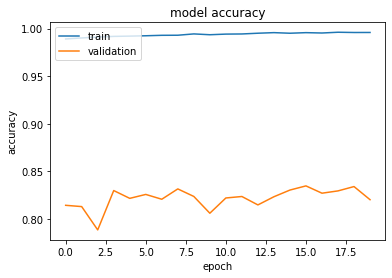

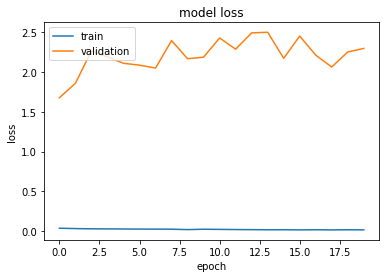

In [38]:
# tensorboard logs 
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [42]:
for layer in model.layers:
    print(layer.name)

input_2
quaternion_conv2d_6
max_pooling2d_6
flatten_2
quaternion_dense_2
dense_2


<Figure size 432x288 with 0 Axes>

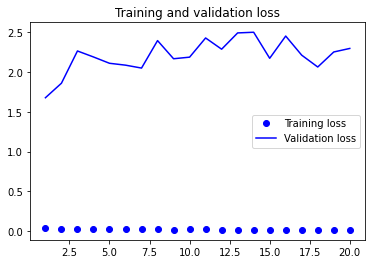

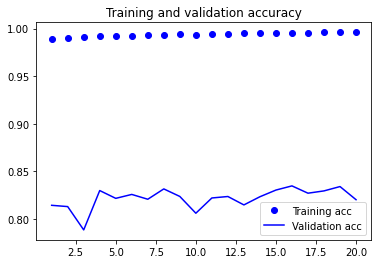

<Figure size 432x288 with 0 Axes>

In [43]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()